<a href="https://colab.research.google.com/github/ancastillar/Transformers-Create-your-own-poem-/blob/main/Transformers_Create_your_own_poem!_with_AI_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import libraries

In [1]:
!pip install aitextgen
!pip install flask-ngrok
!pip install flask==0.12.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 572 kB 7.4 MB/s 
     |████████████████████████████████| 4.4 MB 52.7 MB/s 
     |████████████████████████████████| 87 kB 8.2 MB/s 
     |████████████████████████████████| 585 kB 15.2 MB/s 
     |████████████████████████████████| 140 kB 7.4 MB/s 
     |████████████████████████████████| 596 kB 56.7 MB/s 
     |████████████████████████████████| 419 kB 49.8 MB/s 
     |████████████████████████████████| 1.1 MB 46.0 MB/s 
     |████████████████████████████████| 6.6 MB 39.5 MB/s 
     |████████████████████████████████| 101 kB 13.4 MB/s 
     |████████████████████████████████| 144 kB 58.4 MB/s 
     |████████████████████████████████| 94 kB 2.6 MB/s 
     |████████████████████████████████| 271 kB 49.8 MB/s 
  Created wheel for aitextgen: filename=aitextgen-0.5.2-py3-none-any.whl size=575905 sha256=708280be7d74fad6d99ce6a7691415d51bc9a52bacccd7cda342cdca72f57

In [1]:
import pandas as pd
import numpy as np


#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

sns.set(rc = {'figure.figsize':(35,10)})
sns.set_palette("Paired")
sns.set_style("white")
from flask import Flask, request, render_template
from flask_ngrok import run_with_ngrok

##########Models
from aitextgen import aitextgen
import torch
import sys
import os
import random
import time 
import datetime

if torch.cuda.is_available():
    current_device = torch.cuda.current_device()
    print("Available GPUs: ", torch.cuda.get_device_name(current_device))
    print()

!nvidia-smi

import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, AdamW, get_linear_schedule_with_warmup, GPT2TokenizerFast
from torch.utils.data import Dataset, random_split, DataLoader, RandomSampler, SequentialSampler

Available GPUs:  Tesla T4

Sun Jul  3 15:18:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                             

## Import Data

In [2]:
col_poem = "stanza_text"

#------------------------------------------------

df_poems = pd.read_csv("/content/drive/MyDrive/proyecto_NLP/data/poe_poems_stanzas.csv")
df_poems = df_poems[(df_poems[col_poem].notna()) & (df_poems[col_poem]!=" ")]

df_poems = df_poems.drop(137, axis=0)
print("Dimension of datase:", df_poems.shape)

Dimension of datase: (214, 2)


##📜 Global Functions

In [3]:
class PoemDataset(Dataset):
    
    def __init__(self, data, tokenizer, max_length, gpt2_type='gpt2'):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.attn_masks = []
        
        for i in data:
          
            encodings_dict = tokenizer('<BOS>' + i + '<EOS>',
                                     truncation=True,
                                     max_length=max_length,
                                     padding='max_length'
                                    )

            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

    def __len__(self):
        
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        
        return self.input_ids[idx], self.attn_masks[idx]



#----------------------------------------------------------------------------------------------------------------------------------------------------

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))
    

#-----------------------------------------------------------------------------------------------------------------------------------------------------

def train_val_split(split, dataset):

    train_size = int(split * len(dataset))
    val_size = len(dataset) - train_size
    return train_size, val_size



In [4]:
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------

RANDOM_SEED = 73
BATCH_SIZE = 2
epochs = 20
MAX_LEN = 1024
home_directory = "/content/drive/MyDrive/proyecto_NLP/models"
###################################################################################################################################################################################################

pretrained_weights = 'gpt2' ## as over 1.5 billion parameters
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_weights)

special_tokens_dict = {'bos_token': '<BOS>', 'eos_token': '<EOS>', 'pad_token': '<PAD>'}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

loading file https://huggingface.co/gpt2/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/684fe667923972fb57f6b4dcb61a3c92763ad89882f3da5da9866baf14f2d60f.c7ed1f96aac49e745788faa77ba0a26a392643a50bb388b9c04ff469e555241f
loading file https://huggingface.co/gpt2/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/c0c761a63004025aeadd530c4c27b860ec4ecbe8a00531233de21d865a402598.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/gpt2/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/gpt2/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/gpt2/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/gpt2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/fc674cd6907b4c9e933cb42d67662436b89fa9540a1f40d7c919d0109289ad01.7d2e0efa5ca20cef4fb1993821

# 🕸 Text Generation - GPT-2

In [5]:
combined_poems = df_poems.groupby(['title'])[col_poem].transform(lambda x: ''.join(x)).drop_duplicates().reset_index(drop=True)

In [6]:
max_poem_length = max([len(tokenizer.encode(poem)) for poem in combined_poems])
min_poem_length = min([len(tokenizer.encode(poem)) for poem in combined_poems])
print('Longest Poem:', max_poem_length, 'tokens long.')
print('Shortest Poem:', min_poem_length, 'tokens long.')

Token indices sequence length is longer than the specified maximum sequence length for this model (1668 > 1024). Running this sequence through the model will result in indexing errors


Longest Poem: 4427 tokens long.
Shortest Poem: 55 tokens long.


In [7]:
stanza_length = [len(tokenizer.encode(stanza)) for stanza in df_poems[col_poem].values]
max_stanza_length = max(stanza_length)
min_stanza_length = min(stanza_length)
print('Number of stanzas longer than max length: ', sum([st_len > MAX_LEN for st_len in stanza_length])) 
print('Longest Stanza:', max_stanza_length, 'tokens long.')
print('Shortest Stanza:', min_stanza_length, 'tokens long.')

Number of stanzas longer than max length:  0
Longest Stanza: 875 tokens long.
Shortest Stanza: 15 tokens long.


In [8]:
poem_dataset = PoemDataset(df_poems[col_poem].values, tokenizer, max_length=MAX_LEN)

##🐝 Train-Test Split

In [9]:
#------------------------------------------------------------------------------------------------------------------------------------

poem_train_size, poem_val_size = train_val_split(0.8, poem_dataset)

# random split imported from troch.utils
poem_train_dataset, poem_val_dataset = random_split(poem_dataset, [poem_train_size, poem_val_size])


#-------------------------------------------------------Random Seeds

torch.cuda.manual_seed_all(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

##🐝 Data Loaders

In [10]:
poem_train_dataloader = DataLoader(poem_train_dataset,
                              sampler=RandomSampler(poem_train_dataset),
                              batch_size=BATCH_SIZE)

poem_val_dataloader = DataLoader(poem_val_dataset,
                            sampler=SequentialSampler(poem_val_dataset),
                            batch_size=BATCH_SIZE)

#-------------------------------------------------------------------------------------------------------------

# helper function for logging time
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

# hyperparameters
learning_rate = 1e-4
eps = 1e-8
warmup_steps = 35
# this produces sample output every 100 steps
sample_every = 50

# create text generation seed prompt
device = torch.device('cuda')

prompt = "<BOS>"
generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

##🚀 FineTunning: Training

In [11]:
configuration = GPT2Config(vocab_size=len(tokenizer), n_positions=MAX_LEN).from_pretrained('gpt2', output_hidden_states=True)

poem_model = GPT2LMHeadModel.from_pretrained('gpt2', config=configuration)

poem_model.resize_token_embeddings(len(tokenizer))

poem_model.cuda()

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(poem_model.parameters(), lr=learning_rate, eps=eps)

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(poem_train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps)

#------------------------------------------------------------------------------------------------------------------

loading configuration file https://huggingface.co/gpt2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/fc674cd6907b4c9e933cb42d67662436b89fa9540a1f40d7c919d0109289ad01.7d2e0efa5ca20cef4fb199382111e9d3ad96fd77b849e1d4bed13a66e1336f51
Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "output_hidden_states": true,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params

In [12]:
total_t0 = time.time()

training_stats = []
total_t0 = time.time()

training_stats = []


poem_model = poem_model.to(device)

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

poem_model = poem_model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    poem_model.train()

    for step, batch in enumerate(poem_train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        poem_model.zero_grad()        

        outputs = poem_model(b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(poem_train_dataloader), batch_loss, elapsed))

            poem_model.eval()

            sample_outputs = poem_model.generate(
                                    bos_token_id= random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = MAX_LEN,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            poem_model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(poem_train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================entario
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    poem_model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in poem_val_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = poem_model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(poem_val_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

torch.save(poem_model.state_dict(), home_directory + 'poem_stanza_model.pth')


Training complete!
Total training took 0:00:00 (h:mm:ss)

======== Epoch 1 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of     86. Loss: 1.3012336492538452.   Elapsed: 0:00:36.
0:  Poké2

  Average training loss: 2.07
  Training epoch took: 0:01:13

Running Validation...
  Validation Loss: 0.68
  Validation took: 0:00:05

======== Epoch 2 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of     86. Loss: 0.5000213980674744.   Elapsed: 0:00:36.
0: avens

  Average training loss: 0.55
  Training epoch took: 0:01:13

Running Validation...
  Validation Loss: 0.65
  Validation took: 0:00:05

======== Epoch 3 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of     86. Loss: 0.9047629237174988.   Elapsed: 0:00:37.
0:  Erd, and her crown.

  Average training loss: 0.51
  Training epoch took: 0:01:13

Running Validation...
  Validation Loss: 0.64
  Validation took: 0:00:05

======== Epoch 4 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of     86. Loss: 0.37863612174987793.   Elapsed: 0:00:37.
0:  sensors

Familiar bells

Are drawn by the air

Familiar bells

Are drawn by the air


This, this, this, this

 this, this

 this, this

 this, this, this, this


this, this, this
 this, this, this, this


this, this, this, this

this, this

this, this

this, this

this, this, this

this, this

—
—
 
The first, the second—
 

the first—

 the second—
 
the second—
 
the second—


 

 The first, the second—
 
the second—
 

the second—
 
The first—
 
 
— 
 
 
 

 
 
 

 
 
 
— 
   
— 
   
 
 
 
 
 
 
 
 
— 
   
  
 
 
 
 

 
 
 
 
 
 
  
   
 
  
 
 
  
    
  
 
  
 
    
  
 
  
 
 
    
 
  
  
  
 
 
    
 
  
   
  
 
    
  
 
 
     
   
        
  
   
   
   
 
   
   
   
    
     
     
      
    
   
      
  
       
   
     
     
    
      
      
       
      
    
         
     
    
   
    
      
      
       
       
      
     
       
      
        
      
      
    
     
      

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of     86. Loss: 0.6465129256248474.   Elapsed: 0:00:36.
0: atilityThe winds are ringing, that seem to be ringing—
And you are struggling—but not yet,
And you feel the danger of waking
And dreaming. Note Note Note Note
 Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note Note 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of     86. Loss: 0.3684578835964203.   Elapsed: 0:00:36.
0:  heav
Into the air is the voice of all living things
Of a strange world in dreams
Of a dream to be 
With the same passion I heard, 
A lone eagle, whose wings were golden 
Whose flight was all-round 
And whose flight was all-round 
Into a strange star
And its winds are the terror of the seas—
And its stars are the wildest 
Their fears of the sea 
And those who dwell in the woods
Are the harlots of the mountain 
And the wild-clowns of the moose 
Who keep my hair—
And the misty night in my room 
And the gray mist in my bed 
Are the fears of the sea 
My fears of the night 
Have passed and gone out 
And the dread that fell upon my bed 
My fears that were still 
Of waking, and my fears that were still 
Whereby I may well cherish 
The memories of life—which I cherish to this day—
For I cherish this life no less—I cherish not only the things that I have 
While it is written, the things that I have 
That I have read in m

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of     86. Loss: 0.4025140702724457.   Elapsed: 0:00:36.
0:  DannyIn thine own voice
 But in her own song,
 On its very wings she trembled 
 And whispered her love—the theme of her beauty—
 By her melodies, I may safely

  Average training loss: 0.43
  Training epoch took: 0:01:12

Running Validation...
  Validation Loss: 0.63
  Validation took: 0:00:05

======== Epoch 8 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of     86. Loss: 0.33963412046432495.   Elapsed: 0:00:36.
0:  AmongSome who are dead and buried
 Of my spirit-filled waters, 

Whose waters have not thine eyes,
Their shore-swept skies, 
And whose flowers have not died!
They were not the light of life 
Though they stood upright in the garden
And wore the stars:
Their fountains were the light of glory. 
For all these days I weep 
With tears that will not go 
Unwritten
That my heart—and that my spirit—
Is not driven 
To weep—
By a mad passion of the heart! 
For it will lie, 
By a mad desire of the head—
It will be a dream.

  Average training loss: 0.42
  Training epoch took: 0:01:12

Running Validation...
  Validation Loss: 0.63
  Validation took: 0:00:05

======== Epoch 9 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of     86. Loss: 0.41341373324394226.   Elapsed: 0:00:36.
0: avorite-at-midnight,
 Ah, though, my friends: my sorrow in her,
 Unadulterated,
 She dined, with those she loved,
 Like the last year and a half 
 In this world of mine.

  Average training loss: 0.42
  Training epoch took: 0:01:12

Running Validation...
  Validation Loss: 0.63
  Validation took: 0:00:05

======== Epoch 10 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of     86. Loss: 0.32568642497062683.   Elapsed: 0:00:36.
0: cialAnd then said, "Ah! Why didst Thou, O God, teach these things? Thou whoest a lord?" Ah! let us not see that in these things, that thy angels, whom thou shouldst envy, didst not descend to the light of the Sun, though in Thy sight were the Earth illumined, and then went about dreaming on a throne of light and beauty—with a star in his right hand 
 The Goddess was born to them, and bore them to their eternal life!

  Average training loss: 0.40
  Training epoch took: 0:01:12

Running Validation...
  Validation Loss: 0.63
  Validation took: 0:00:05

======== Epoch 11 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of     86. Loss: 0.4681466221809387.   Elapsed: 0:00:36.
0: anyahu:—
 "There is no time!
The Future Is Past!"
How can you feel it?
There are no hopes,
Too feeble to hope,
Too feeble to aspire—
Too feeble—not only to seek
To some remote future,
But to see, in dreams,
Into dreams of deep thought.

  Average training loss: 0.39
  Training epoch took: 0:01:12

Running Validation...
  Validation Loss: 0.64
  Validation took: 0:00:05

======== Epoch 12 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of     86. Loss: 0.5876380801200867.   Elapsed: 0:00:36.
0: Group. name. ( "Mystique de l

  Average training loss: 0.38
  Training epoch took: 0:01:12

Running Validation...
  Validation Loss: 0.64
  Validation took: 0:00:05

======== Epoch 13 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of     86. Loss: 0.42285630106925964.   Elapsed: 0:00:36.
0:  BeerThy eyes 
 A ghastly blush 
 Is down on my face, like a rosemary plant 
 In flowers that were never before 
 And thus my spirit died—
 And my heart never breathed
 My spirit never passed,
 Never—never—never—
 As a feeling of joy on a burning July eve 
 (Though my heart—
 So let it be) 
 My spirit is dead—
 A melancholy dream, a sinking feeling 
 Of my melancholyness as if that spirit 
 Had fallen within the breast of an eagle 
 So that its heart was upon a thousand lilies, 
 And a ghastly blush 
 Is down on my face, like a plant that was never before—
 A ghoul's heart is on my heart as a burning flower 
 In flowers that were never before 
 And thus my spirit died— 
 A dream in hopes that my spirit may never leave my presence—
 A melancholy dream in hopes that my spirit may never return 
 Note Contents

  Average training loss: 0.37
  Training epoch took: 0:01:12

Running Validation...
  Validation Loss: 0.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of     86. Loss: 1.110690951347351.   Elapsed: 0:00:36.
0: iasmAt length, the moon turned, And from its upturn'd rim, sprang a bird That thronged, till it soared above
 At the tops of the gaudy walls of Raven's Cove. 1827 Contents p. 2

  Average training loss: 0.36
  Training epoch took: 0:01:13

Running Validation...
  Validation Loss: 0.65
  Validation took: 0:00:05

======== Epoch 15 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of     86. Loss: 0.3335363566875458.   Elapsed: 0:00:36.
0:  prosecutThen I saw the angels, sitting so high above,
And they would not let me go, 
When the angelials trailed behind me, 
From their way of flying,
From their way of repose
By the swiftest of those naphthalines.
For at my hand I held
A wand of Fate, a gift, 
And to me a token of my gratitude. 1849 Contents p. 3

  Average training loss: 0.35
  Training epoch took: 0:01:12

Running Validation...
  Validation Loss: 0.65
  Validation took: 0:00:05

======== Epoch 16 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of     86. Loss: 0.5708314776420593.   Elapsed: 0:00:36.
0: mouthAt thine isle, 
 In thy greenest name 
 And the solemn wreath 
 Which floats above thy holier dell
 Are the roses, my dear Love! O, her Love! 
 Thy perfume is a symbol 
 Of love that binds 
 Its prey, even if that prey 
 Is itself the idol!

  Average training loss: 0.34
  Training epoch took: 0:01:12

Running Validation...
  Validation Loss: 0.66
  Validation took: 0:00:05

======== Epoch 17 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of     86. Loss: 0.2291187345981598.   Elapsed: 0:00:36.
0: owersThe bells
That the choir bells, by their own gurgles,
Gurgled wildly about their high-mouthed,
Rendered from the distant hills, 
Rendered from the same source that thine
Bastards from the same town had ridden
In the same troop,
In the same troop, and in the same troop,
Rendered from the same source that thine own
Beloved, the good Lenore of Rome, 
Rendered from the same source that thine own home had been 
In the same tomb of Ulal III. 
Rendered from the same source that Thante himself had given
To his mother, whose dews were made
On a velvet couch of velvet—
And whose chains he bound,
On a velvet velvet bed of velvet—
And whose girdles he bound, 
On a velvet curtain that bound all that slept 
On a velvet bed of velvet.

  Average training loss: 0.34
  Training epoch took: 0:01:13

Running Validation...
  Validation Loss: 0.66
  Validation took: 0:00:05

======== Epoch 18 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of     86. Loss: 0.5555798411369324.   Elapsed: 0:00:36.
0:  commalmed

  Average training loss: 0.34
  Training epoch took: 0:01:12

Running Validation...
  Validation Loss: 0.66
  Validation took: 0:00:05

======== Epoch 19 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of     86. Loss: 0.18550468981266022.   Elapsed: 0:00:36.
0: nesota

When that day came (
 Where the night shall lie)
 And the angels cheered on,
 That the pallid air
 And the angels cheered on, 
 And the birds cheered on,
 That the gray-haired bees cheered 
 On the reared pheasants 
 And the lilies cheered, and the bees cheered,
 But all that night—
 All that night—
 In all that night 
 I feel as if the sky 
 Is a pallid night, and the stars 
 Chime in the woofing sound,
 And the murmured moaning of the bees 
 Are the accompaniment to the moaning and the wailing.

  Average training loss: 0.33
  Training epoch took: 0:01:12

Running Validation...
  Validation Loss: 0.66
  Validation took: 0:00:05

======== Epoch 20 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of     86. Loss: 0.18914002180099487.   Elapsed: 0:00:36.
0:  waitedThere were murmuring beside me as if dreaming; 
And when, then, suddenly, 
(like things in dreams, 
Dim in tone)
The moon rose and died—
And from a deep pride
A maiden of Earth—
Fell in beauty, and from a chilly pride
Fell within me like a cloud.

  Average training loss: 0.33
  Training epoch took: 0:01:12

Running Validation...
  Validation Loss: 0.66
  Validation took: 0:00:05

Training complete!
Total training took 0:25:53 (h:mm:ss)


## 👨‍🚀 Summary of the training process

In [13]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,2.07,0.68,0:01:13,0:00:05
2,0.55,0.65,0:01:13,0:00:05
3,0.51,0.64,0:01:13,0:00:05
4,0.49,0.63,0:01:13,0:00:05
5,0.47,0.64,0:01:13,0:00:05
6,0.45,0.63,0:01:13,0:00:05
7,0.43,0.63,0:01:12,0:00:05
8,0.42,0.63,0:01:12,0:00:05
9,0.42,0.63,0:01:12,0:00:05


## 👨‍🚀 Performance Summary

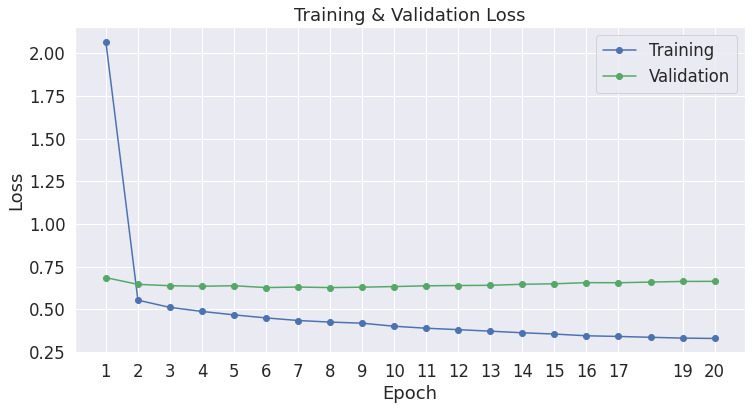

In [14]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5, 6, 7,8,9,10,11,12,13,14,15,16,17,19,20])

plt.show()

##🌌 Model Info

In [15]:
# Get all of the model's parameters as a list of tuples.
params = list(poem_model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50260, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

##  Saving & Loading Fine-Tuned Model


In [16]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = home_directory +'/model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = poem_model.module if hasattr(poem_model, 'module') else poem_model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to /content/drive/MyDrive/proyecto_NLP/models/model_save/


Configuration saved in /content/drive/MyDrive/proyecto_NLP/models/model_save/config.json
Model weights saved in /content/drive/MyDrive/proyecto_NLP/models/model_save/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/proyecto_NLP/models/model_save/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/proyecto_NLP/models/model_save/special_tokens_map.json
added tokens file saved in /content/drive/MyDrive/proyecto_NLP/models/model_save/added_tokens.json


('/content/drive/MyDrive/proyecto_NLP/models/model_save/tokenizer_config.json',
 '/content/drive/MyDrive/proyecto_NLP/models/model_save/special_tokens_map.json',
 '/content/drive/MyDrive/proyecto_NLP/models/model_save/vocab.json',
 '/content/drive/MyDrive/proyecto_NLP/models/model_save/merges.txt',
 '/content/drive/MyDrive/proyecto_NLP/models/model_save/added_tokens.json')

In [17]:
home_directory+'/model_save/'

'/content/drive/MyDrive/proyecto_NLP/models/model_save/'

In [18]:
!ls -l --block-size=K /content/drive/MyDrive/proyecto_NLP/models/model_save/

total 499869K
-rw------- 1 root root      1K Jul  3 15:45 added_tokens.json
-rw------- 1 root root      1K Jul  3 15:45 config.json
-rw------- 1 root root    446K Jul  3 15:45 merges.txt
-rw------- 1 root root 498444K Jul  3 15:45 pytorch_model.bin
-rw------- 1 root root      1K Jul  3 15:45 special_tokens_map.json
-rw------- 1 root root      1K Jul  3 15:45 tokenizer_config.json
-rw------- 1 root root    976K Jul  3 15:45 vocab.json


In [19]:
!ls -l --block-size=M /content/drive/MyDrive/proyecto_NLP/models/model_save/pytorch_model.bin

-rw------- 1 root root 487M Jul  3 15:45 /content/drive/MyDrive/proyecto_NLP/models/model_save/pytorch_model.bin


In [ ]:
# Copy the model files to a directory in your Google Drive.
#!cp -r /content/drive/MyDrive/proyecto_NLP/models/model_save/  $data_dir

# # Load a trained model and vocabulary that you have fine-tuned
#model = GPT2LMHeadModel.from_pretrained(output_dir)
#tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
#model.to(device)

cp: missing destination file operand after '/content/drive/MyDrive/proyecto_NLP/models/model_save/'
Try 'cp --help' for more information.


##Poems Generation

In [27]:
poem_model.eval()

prompt = 'love is'

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = poem_model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=40, 
                                max_length = 100,
                                top_p=0.95, 
                                num_return_sequences=3,
                                num_beams=5, no_repeat_ngram_size=4, early_stopping=True
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: love is the light of the night—
 And the shadow of the mountain 
 And the mist of the sea 
 Is a barrier—
 And a barrier that will not be broken 
 By the battle-cry 
 Of the trumpet-thunder-thunder,
 But by the roar of the battle 
 Shall be the battle cry of the dead 
 And shall be the cry of the living—
 And by the roar shall be the roar
 Of the battle-


1: love is the light of life;
It glows in the dim of night;
It flickers with the light of day,
And in the mist of day, 
It trembles with the chilly eye 
Of the lonesome and the dead.


2: love is a synonym for love,
 For love is a double-edged sword—
 And love is a gift from God—
 For the love of God is a gift of life—
 And the love of man is a gift given by God—
 And we are saved only by the grace of God."




In [29]:
poem_model.eval()

prompt = 'heaven is good'

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = poem_model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=40, 
                                max_length = 150,
                                top_p=0.95, 
                                num_return_sequences=3,
                                num_beams=5, no_repeat_ngram_size=4, early_stopping=True
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: heaven is good, and light is light;
And all things which are holy, 
Are light, and all things which seem 
To be a gift from God to us, 
And to us a token of our gratitude. 18
¹ ¿ 18


1: heaven is good,
And the winds are gentle, 
And the skies are clear—
And the stars seem to be smiling—
And there is no need 
To sing the hymns of the hymn-winds, 
Unless, perhaps, you are a poet or a hymn-stringer—
And you will sing the hymn of the sun-ray, 
Of the moon-ray,
Of the stars,
And there will be no need
For you to sing the song of the moon, 
 Of the stars, or of the angels, 
With the accompaniment of the bells and the bells of the bells, 
So that you may feel no need


2: heaven is good, 
 And all things are light, 
 That is, I believe, the reason 
 That all things are bright—
 And all that is gray—
 That all that is sad, 
 Is the reason that all things seem 
 To be of one essence, 
 But that all things are of one essence—
 And that all things—all things—have one essence— 
 The reason why 